# Laplacian Spectral Kernel

In [1]:
import numpy as np
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity
from scipy.sparse import csgraph
from graspologic.utils import pass_to_ranks, to_laplacian
from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()

In [2]:
from graspologic.datasets import load_mice

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

(32, 332, 332)


## Replicating Figure from {cite:t}`suarez2022taxonomy`

We attempt to replicate (a) and (b) from the following figure from the MaMI paper using the laplacian spectral kernel we constructed. The code for the laplacian spectral kernel is attached below.

![MaMI Figure](./mami_figure.png)

In [3]:
# HIDE CODE
def laplacian_dissim(graphs, transform: str=None, metric: str='l2', smooth_eigvals: bool=False, \
    normalize=True):
    if transform == 'pass-to-ranks':
        for i, graph in enumerate(graphs):
            graph = pass_to_ranks(graph)
            graphs[i] = graph
    elif transform == 'binarize':
        graphs[graphs != 0] = 1
    elif transform == None:
        graphs = graphs
    else:
        print('Supported transformations are "pass-to-ranks" (simple-nonzero), "binarize", or None.')
    
    eigs = []
    for i, graph in enumerate(graphs):
        # calculate laplacian
        lap = to_laplacian(graph, 'I-DAD')

        # find and sort eigenvalues
        w = np.linalg.eigvals(lap)
        w = np.sort(w)

        if smooth_eigvals:
            kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(w.reshape(-1, 1))
            xs = np.linspace(0, 2, 2000)
            xs = xs[:, np.newaxis]
            log_dens = kde.score_samples(xs)
            eigs.append(np.exp(log_dens))
        else:
            eigs.append(w)

    dissim_matrix = np.zeros((len(graphs), len(graphs)))
    for i, eig1 in enumerate(eigs):
        for j, eig2 in enumerate(eigs):
            if metric == 'cosine':
                diff = cosine(eig1, eig2)
            elif metric == 'l1':
                diff = np.linalg.norm(eig1 - eig2, ord=1)
            elif metric == 'l2':
                diff = np.linalg.norm(eig1 - eig2, ord=2)
            dissim_matrix[i, j] = diff

    if normalize:
        dissim_matrix = dissim_matrix / np.max(dissim_matrix)
    
    return dissim_matrix

### Preprocessing Data

First, let's load in the data.

In [6]:
# HIDE CELL
### load data
from pathlib import Path
import random
import pandas as pd

graphs_all = np.zeros((225, 200, 200))
species_list = []

npy_files = Path('../mami_data/conn').glob('*')
for i, file in enumerate(npy_files):
    graphs_all[i] = np.load(file)
    filestr = str(file).split('/')[-1]
    filestr = filestr.split('.')[0]
    species_list.append(filestr)

random.seed(3)

# construct labels based on taxonomy orders
info_df = pd.read_csv('../mami_data/info.csv')
filenames = info_df.pop("Filename").to_list()
orders_all = info_df.pop("Order").to_list()
#print(orders_all)

order_mapper = {}
for i, filename in enumerate(filenames):
    if orders_all[i] == 'Artiodactyla':
        orders_all[i] = 'Cetartiodactyla'
    order_mapper[filename] = orders_all[i]

labels_all = list(map(order_mapper.get, species_list))

# get subset of labels, graphs
orders = ['Chiroptera', 'Rodentia', 'Cetartiodactyla', 'Carnivora', 'Perissodactyla', 'Primates']
ind = []
labels = []

for i, label in enumerate(labels_all):
    if label in orders:
        labels.append(label)
        ind.append(i)
        
graphs = graphs_all[ind]
mapper = {}

for i, label in enumerate(set(labels)):
    mapper[label] = i
y = list(map(mapper.get, labels))

print(len(labels))
print(len(y))

203
203


Next, we sort the labels and graphs such that they match the order from the figure.

In [7]:
# HIDE CELL
values, counts = np.unique(np.array(labels), return_counts = True)
val_counts_dict = {}
for i, value in enumerate(values):
    val_counts_dict[value] = counts[i]

values_sorted = ['Chiroptera', 'Rodentia', 'Cetartiodactyla', 'Carnivora', 'Perissodactyla', 'Primates']

counts_sorted = []
for value in values_sorted:
    counts_sorted.append(val_counts_dict[value])

labels_sorted = list(np.repeat(values_sorted, counts_sorted))

graphs_sorted = []
for i, label in enumerate(labels_sorted):
    idx = labels.index(label)
    labels[idx] = 0
    graphs_sorted.append(graphs[idx])

graphs_sorted = np.array(graphs_sorted)

print(np.shape(graphs_sorted))

(203, 200, 200)


### Figure (a) 
In {cite:t}`suarez2022taxonomy`, the Laplacian eigenspectrum for each binarized graph was smoothed using a Gaussian kernel, and dissimilarity was calculated as the cosine difference between the eigenspectra. Thus, we use parameters `transform='binarize'`, `metric='cosine'`, and `smooth_eigvals=True` in our `laplacian_dissim` function to replicate the process used in the paper, then we use `transform='zero-boost'` when plotting the heatmap to make it visually more similar.

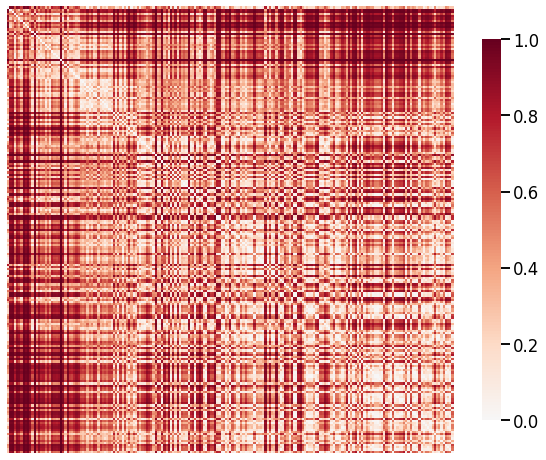

In [9]:
# HIDE CODE
scaled_lap_dissim_sorted = laplacian_dissim(graphs_sorted, transform='binarize', metric='cosine', \
    smooth_eigvals=True, normalize=False)

ax = heatmap(scaled_lap_dissim_sorted, transform='zero-boost', context="talk")
ax.figure.set_facecolor('w')

The original figure from the paper seems to have the graphs sorted within the orders (labels), but we see that the replicate figure follows the same general trends, where the Chiroptera-Primate cell is the darkest and the Primate-Primate cell is the lightest.

### Figure (b)
When replicating Figure (b) and calculating the median dissimilarity values within and between orders, we focus mostly on the trends and not so much on the raw values.

#### No Transformation
First, we calculate and display the raw median values.

[Text(0.5, 0, 'Chiroptera'),
 Text(1.5, 0, 'Rodentia'),
 Text(2.5, 0, 'Cetartiodactyla'),
 Text(3.5, 0, 'Carnivora'),
 Text(4.5, 0, 'Perissodactyla'),
 Text(5.5, 0, 'Primates')]

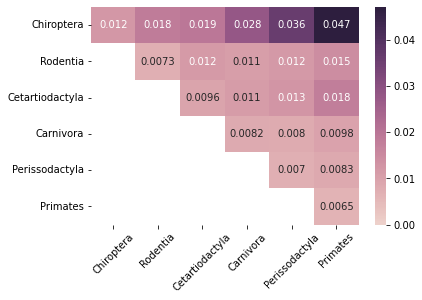

In [10]:
# HIDE CODE
dissim_median = np.zeros((6, 6))
labels_sorted = np.array(labels_sorted)
for i, label1 in enumerate(values_sorted):
    for j, label2 in enumerate(values_sorted):
        mask = (labels_sorted[:, None] == label1) & (labels_sorted[ None, :] == label2)
        dissim_median[i, j] = np.median(scaled_lap_dissim_sorted[mask])

import seaborn as sns
import matplotlib.pyplot as plt
mask = np.tril(np.ones_like(dissim_median), -1)
plt.figure(facecolor='w')
cmap = sns.cubehelix_palette(as_cmap=True)
ax = sns.heatmap(dissim_median, mask=mask, annot=True, vmin=0, cmap=cmap)
ax.set_yticklabels(values_sorted, rotation=0)
ax.set_xticklabels(values_sorted, rotation=45) 

#### Pass-to-Ranks Transformation
We observe that the values are much smaller than those in the original figure, so we try applying a pass-to-ranks transformation on the median matrix, then setting the colorbar scale from 0 to 1.

[Text(0.5, 0, 'Chiroptera'),
 Text(1.5, 0, 'Rodentia'),
 Text(2.5, 0, 'Cetartiodactyla'),
 Text(3.5, 0, 'Carnivora'),
 Text(4.5, 0, 'Perissodactyla'),
 Text(5.5, 0, 'Primates')]

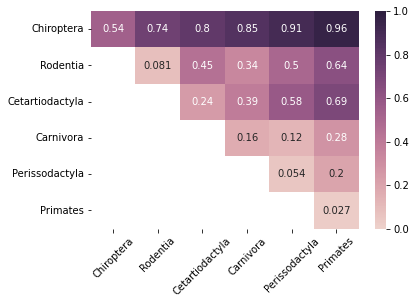

In [12]:
# HIDE CODE
dissim_median = np.zeros((6, 6))
labels_sorted = np.array(labels_sorted)
for i, label1 in enumerate(values_sorted):
    for j, label2 in enumerate(values_sorted):
        mask = (labels_sorted[:, None] == label1) & (labels_sorted[ None, :] == label2)
        dissim_median[i, j] = np.median(scaled_lap_dissim_sorted[mask])

dissim_median_transformed = pass_to_ranks(dissim_median)
import seaborn as sns
import matplotlib.pyplot as plt
mask = np.tril(np.ones_like(dissim_median_transformed), -1)
plt.figure(facecolor='w')
cmap = sns.cubehelix_palette(as_cmap=True)
ax = sns.heatmap(dissim_median_transformed, mask=mask, annot=True, vmin=0, vmax=1, cmap=cmap)
ax.set_yticklabels(values_sorted, rotation=0)
ax.set_xticklabels(values_sorted, rotation=45) 

For both methods, we see that the values are slightly different but the general trends seem to be consistent with the original figure except for the Chiroptera-Chiroptera cell. This may be due to transformations that the paper applied to either the dissimilarity matrix or the median matrix that the paper did not mention, or the authors may have removed graphs within the Chiroptera order that were very dissimilar to each other as outliers. Overall, since we are able to replicate the trends from original figure for all the other cells, we determine that the Laplacian spectral kernel we built is functional.

## Determining Parameters for Highest Discriminability

To determine which laplacian spectral kernel to use for our analysis, we vary parameters `transform`, `metric`, and `smooth_eigvals` and calculate the discriminability index for each. We use the [Duke Mouse Whole-Brain Connectomes](https://microsoft.github.io/graspologic/latest/reference/reference/datasets.html#graspologic.datasets.load_mice) dataset from Graspologic. Note that these networks are matched.

### Load Data

In [13]:
# HIDE CELL

# load the full mouse dataset
from graspologic.datasets import load_mice
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

# initialize labels
labels = {}
for i in np.arange(0, 332):
    labels[i] = i

(32, 332, 332)


### Pass-to-Ranks Transformation, Smoothing, L1 Norm

0.6499255952380952


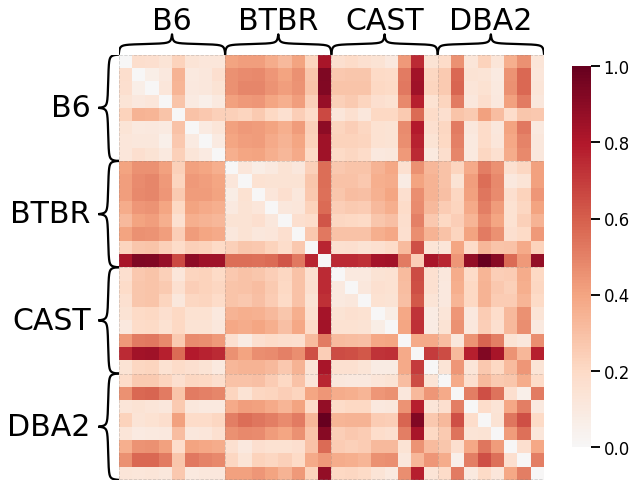

In [14]:
# HIDE CODE

# plot dissimilarity matrix
scaled_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l1', smooth_eigvals=True, \
    normalize=True)

ax = heatmap(scaled_dissim, inner_hier_labels=mice.labels, context="talk")
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# calculate discriminability
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

### No Pass-to-Ranks Tranformation, Smoothing, L1 Norm

0.6499255952380952


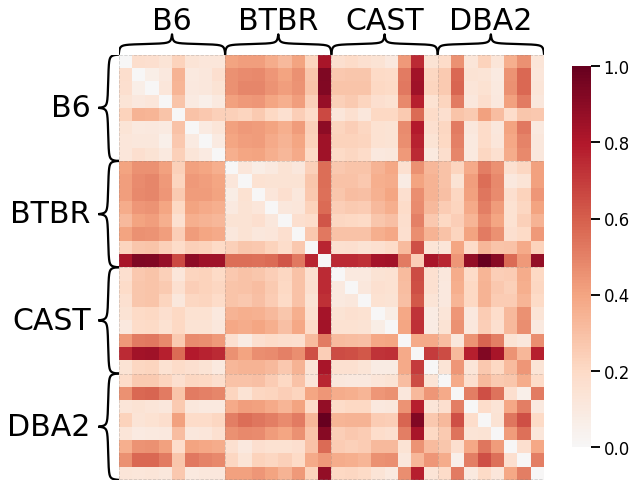

In [15]:
# HIDE CODE

# plot dissimilarity matrix
scaled_dissim = laplacian_dissim(graphs, transform=None, metric='l1', smooth_eigvals=True, \
    normalize=True)

ax = heatmap(scaled_dissim, inner_hier_labels=mice.labels, context="talk")
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# calculate discriminability
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

### Pass-to-Ranks Transformation, No Smoothing, L1 Norm

0.679501488095238


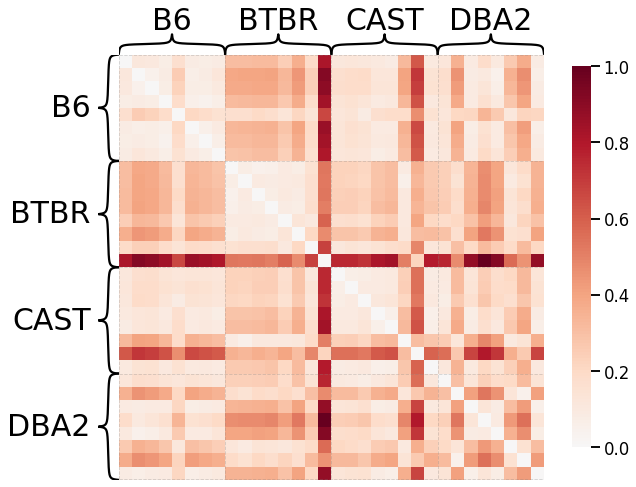

In [16]:
# HIDE CODE

# plot dissimilarity matrix
scaled_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l1', smooth_eigvals=False, \
    normalize=True)

ax = heatmap(scaled_dissim, inner_hier_labels=mice.labels, context="talk")
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# calculate discriminability
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

### Pass-To-Ranks Transformation, Smoothing, L2 Norm

0.6339285714285714


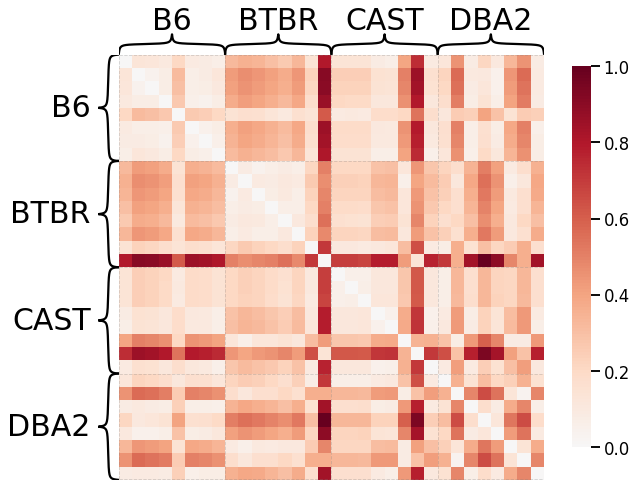

In [17]:
# HIDE CODE

# plot dissimilarity matrix
scaled_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l2', smooth_eigvals=True, \
    normalize=True)

ax = heatmap(scaled_dissim, inner_hier_labels=mice.labels, context="talk")
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# calculate discriminability
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

### No Pass-To-Ranks Transformation, No Smoothing, L1 Norm

0.679501488095238


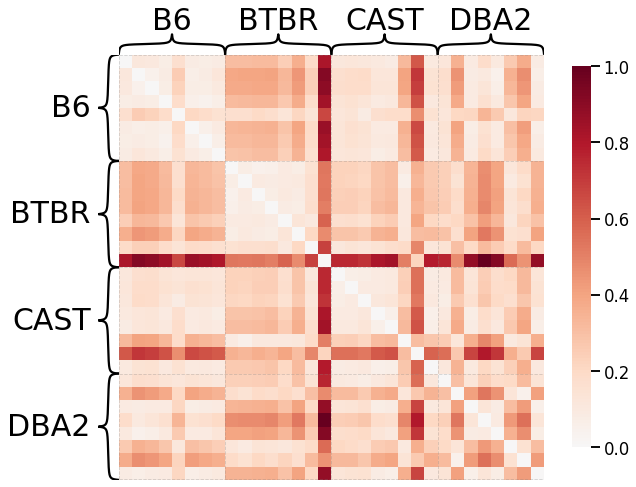

In [18]:
# HIDE CODE

# plot dissimilarity matrix
scaled_dissim = laplacian_dissim(graphs, transform=None, metric='l1', smooth_eigvals=False, \
    normalize=True)

ax = heatmap(scaled_dissim, inner_hier_labels=mice.labels, context="talk")
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# calculate discriminability
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

### No Pass-To-Ranks Transformation, Smoothing, L2 Norm

0.6339285714285714


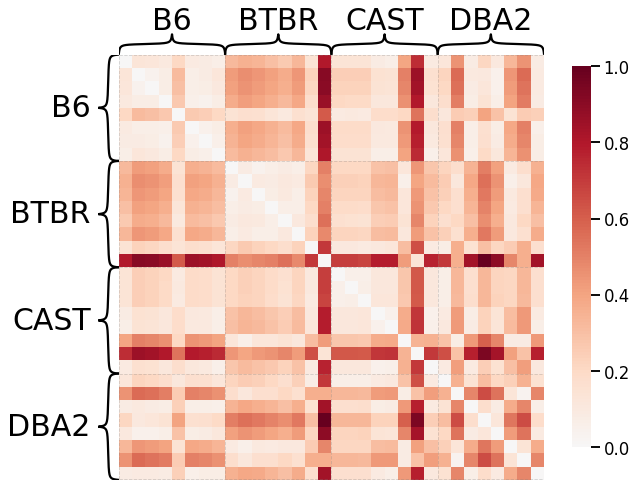

In [19]:
# HIDE CODE

# plot dissimilarity matrix
scaled_dissim = laplacian_dissim(graphs, transform=None, metric='l2', smooth_eigvals=True, \
    normalize=True)

ax = heatmap(scaled_dissim, inner_hier_labels=mice.labels, context="talk")
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# calculate discriminability
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

### Pass-To-Ranks Transformation, No Smoothing, L2 Norm

0.7743675595238095


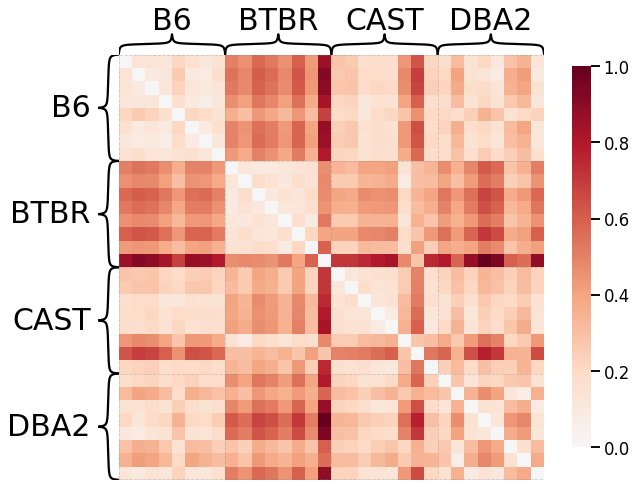

In [20]:
# HIDE CODE

# plot dissimilarity matrix
scaled_dissim = laplacian_dissim(graphs, transform='pass-to-ranks', metric='l2', smooth_eigvals=False, \
    normalize=True)

ax = heatmap(scaled_dissim, inner_hier_labels=mice.labels, context="talk")
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])

# calculate discriminability
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

Based on the results above, we decided to use parameters `transform='pass-to-ranks'`, `metric='l2'`, `smooth_eigvals=False` for the laplacian spectral kernel as it generated a dissimilarity matrix with the highest discriminability index.

# References
```{bibliography}
:filter: docname in docnames
:style: unsrt
```